# TP0: Introducción al Análisis de Datos

### Integrantes:

* Ignacio Negro Caino
* Ivan Chayer
* Thomas Mizrahi
* Tomas Marengo

### Imports y útiles, ejecutar primero

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns
from enum import Enum
from src.pokemon import Pokemon, PokemonFactory, StatusEffect
from src.catching import attempt_catch

In [3]:
factory = PokemonFactory("pokemon.json")

available_pokemon = []
with open("pokemon.json", "r") as pokemon_file:
    pokemon_db = json.load(pokemon_file)
    available_pokemon = [key for key in pokemon_db]

with open("global-config.json", "r") as global_file:
    global_config = json.load(global_file)

POKEBALLS = global_config["pokeballs"]
ITERS = global_config["iterations"]

In [4]:
def make_graph(df):
    # Crear una figura y un eje
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear las barras del gráfico
    x = df["pokeball_"]
    y = df["relative_mean"]
    #error = df["relative_std"]
    #ax.bar(x, y, yerr=error, capsize=5)
    ax.bar(x, y, capsize=5)

    # Configurar el eje x
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=45, ha="right")
    ax.set_xlabel("Pokebola")

    # Configurar el eje y
    ax.set_ylabel("Eficiencia relativa")

    # Añadir título
    ax.set_title("Promedios de eficiencia relativa de las pokebolas respectos a la pokebola común")

    # Mostrar el gráfico
    return plt.show()

In [5]:
def test_pokemon(pokemon_name, level, status, hp_percentage, pokeball_compare):
    pokemon = factory.create(pokemon_name, level, status, hp_percentage)
    df = pd.DataFrame(columns=["pokeball", "success"])
    for pokeball in POKEBALLS:
        for _ in range(ITERS):
            attempt, rate = attempt_catch(pokemon, pokeball)
            new_row = [pokeball, attempt]
            df.loc[len(df)] = new_row
    
    df = df.groupby("pokeball").agg({"success": ["mean", "std"]}).reset_index()
    df.columns = df.columns.map("_".join)
    
    # Find the common pokeball's mean success rate in the dataset
    common_pokeball_mean = 0
    for i in range(len(df)):
        if (df.loc[i]["pokeball_"] == pokeball_compare):
            common_pokeball_mean = df.loc[i]["success_mean"]

    df["relative_mean"] = df.success_mean / common_pokeball_mean
    df["relative_std"] = df.success_std / common_pokeball_mean
    return df

### 1A: Probabilidad de captura promedio para cada pokemon con cada pokebola

Se toman como condiciones "ideales", nivel 100, sin estado (esto no lo dice el enunciado) y con 100% de HP.
Una aclaración, sabiendo la mecánica del juego, es que cuando se nombran las condiciones "ideales" en el primer punto, estas deberían ser HP:1% (o el mínimo numero entero si no es en porcentaje, HP:1) y LVL 100, ya que el entrenador quiere atrapar el pokemon más fuerte (aunque no se encuentren niveles 100 salvajes) con la mayor probabilidad de captura posible (y esto se obtiene cuando el pokemon tiene la menor cantidad de vida posible y un estado favorable como SLEEP o FREEZE).

In [6]:
with open("ejercicio1a-config.json", "r") as file_1a:
    config_1a = json.load(file_1a)

LEVEL = config_1a["level"]
STATUS = StatusEffect[config_1a["status"]]
HP_PERCENTAGE = config_1a["hp_percentage"]


Retomando, teniendo en cuenta cada Pokemon dentro de la base de datos (pokemon.json), y ejecutando 100 veces la función de catching con cada pokebola disponible, obtenemos una tabla que resume los porcentajes de captura en cada una de estas situaciones.

In [7]:
probabilities = {}
for pokemon in available_pokemon:
	probabilities[pokemon] = {}
	pk = factory.create(pokemon, LEVEL, STATUS, HP_PERCENTAGE)
	for pokeball in POKEBALLS:
		captured = 0
		for _ in range(ITERS):
			captured += 1 if attempt_catch(pk, pokeball)[0] else 0
		probabilities[pokemon][pokeball] = captured

df = pd.DataFrame(probabilities)
df.style.background_gradient(cmap="Greens")

,jolteon,caterpie,snorlax,onix,mewtwo
pokeball,4,36,7,4,1
ultraball,17,62,7,15,1
fastball,22,33,5,7,2
heavyball,3,36,7,5,1


### 1B: Efectividad en las pokebolas

Por lo visto anteriormente, donde se evalúa el porcentaje de captura, vemos que para distintos pokemon se obtienen diferentes porcentajes de captura. Esto indica que hay propiedades intrínsecas en los pokemon que hace que el porcentaje de captura sea distinto (esto es así ya que es lo único que está cambiando, pues la pokebola, el nivel, el porcentaje de HP y el estado del pokemon sigue siendo el mismo).

In [8]:
with open("ejercicio1b-config.json", "r") as file_1b:
    config_1b = json.load(file_1b)

LEVEL = config_1b["level"]
STATUS = StatusEffect[config_1b["status"]]
HP_PERCENTAGE = config_1b["hp_percentage"]
POKEBALL_COMPARE = config_1b["pokeball_compare"]

In [9]:
caterpie_df = test_pokemon("caterpie", LEVEL, STATUS, HP_PERCENTAGE, POKEBALL_COMPARE)
caterpie_df.style.background_gradient(cmap="Greens", axis=0).hide(axis='index')

pokeball_,success_mean,success_std,relative_mean,relative_std
fastball,0.370000,0.485237,1.121212,1.470414
heavyball,0.300000,0.460566,0.909091,1.395655
pokeball,0.330000,0.472582,1.000000,1.432065
ultraball,0.650000,0.479372,1.969697,1.452644


Primero podemos ver que para un Caterpie, un pokemon fácil de capturar, la fastball y heavyball se mantienen en los 0.75 de eficiencia relativa

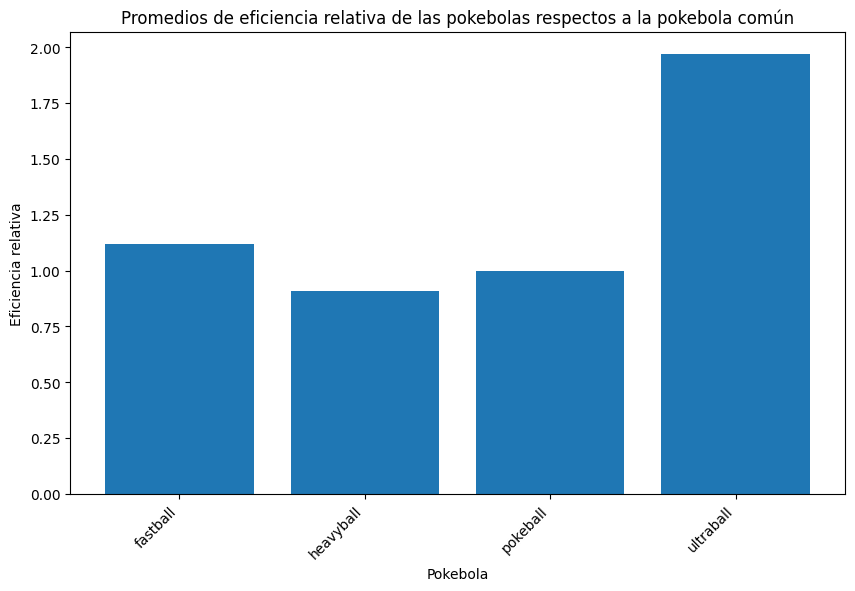

In [10]:
make_graph(caterpie_df)

Pero si pasamos a un jolteon, vemos que su velocidad, es decir una de las propiedades intrínsecas hace que la fastball sea hasta más eficiente que la ultraball.

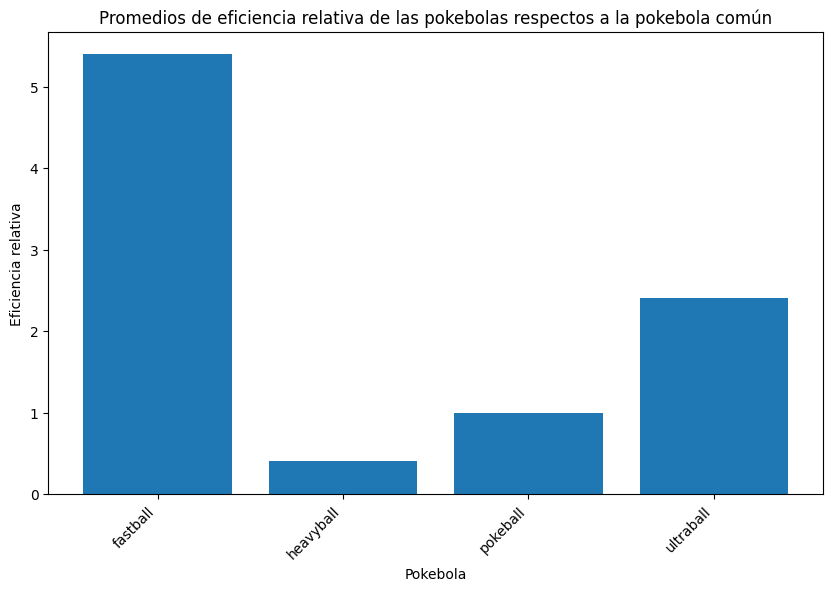

In [11]:
jolteon_df = test_pokemon("jolteon", LEVEL, STATUS, HP_PERCENTAGE, POKEBALL_COMPARE)
make_graph(jolteon_df)

Luego un snorlax tendrá mas ratio de captura con la heavyball, debido a su peso.

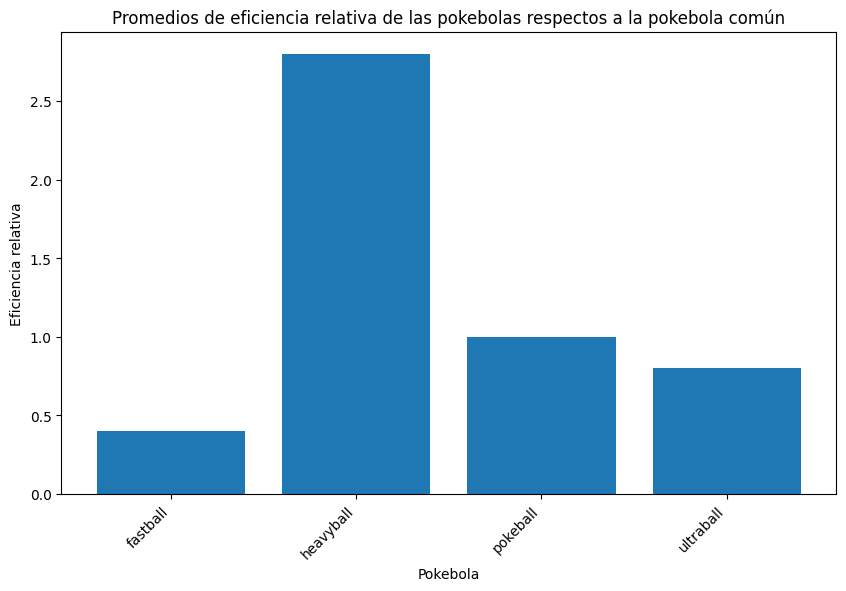

In [12]:
snorlax_df = test_pokemon("snorlax", LEVEL, STATUS, HP_PERCENTAGE, POKEBALL_COMPARE)
make_graph(snorlax_df)

### 2A: Condiciones de salud

Tomamos todos los pokemon en todas las condiciones de salud posibles, y los intentamos capturar 100 veces en cada situación. El resultado muestra que existe una variación según el estado en el que se encuentra el pokemon. Se aprecia que sleep y freeze son los más fuertes pero también que poison, burn y paralysis aumentan el porcentaje de captura

In [13]:
with open("ejercicio2a-config.json", "r") as file_2a:
    config_2a = json.load(file_2a)

LEVEL = config_2a["level"]
HP_PERCENTAGE = config_2a["hp_percentage"]

In [14]:
probabilities = {}
for pokemon in available_pokemon:
	probabilities[pokemon] = {}
	for status in StatusEffect:
		pk = factory.create(pokemon, LEVEL, status, HP_PERCENTAGE)
		captured = 0
		for _ in range(ITERS):
			captured += 1 if attempt_catch(pk, "pokeball")[0] else 0
		probabilities[pokemon][status.value[0]] = captured

df = pd.DataFrame(probabilities)
df.style.background_gradient(cmap="Greens")

,jolteon,caterpie,snorlax,onix,mewtwo
poison,7,52,8,8,0
burn,9,54,4,8,1
paralysis,5,51,5,3,1
sleep,11,62,5,8,0
freeze,10,64,5,11,0
none,8,28,4,3,0


### 2B: Puntos de vida

Para demostrar que los puntos de vida tienen importancia a la hora de capturar un pokemon, tomamos como muestras todos los pokemon disponibles (para demostrar que no sólo uno tiene esta propiedad) con diferentes porcentajes de salud: 100, 80, 60, 40 y 20. Los sometimos a capturas con una misma pokebola (la pokeball, para que no tenga ningún modificador extra) y obtuvimos diferentes porcentajes que son inversamente proporcionales al porcentaje de salud del pokemon.

In [15]:
with open("ejercicio2b-config.json", "r") as file_2b:
    config = json.load(file_2b)

POKEMON_NAME = config["pokemon_name"]
LEVEL = config["level"]
STATUS = StatusEffect[config["status"]]
HP_PERCENTAGES = config["hp_percentages"]
POKEBALL = config["pokeball"]

In [16]:
probabilities = {}
for pokemon in available_pokemon:
	probabilities[pokemon] = {}
	for hp in HP_PERCENTAGES:
		pk = factory.create(pokemon, 100, StatusEffect.NONE, hp)
		captured = 0
		for _ in range(100):
			captured += 1 if attempt_catch(pk, "pokeball")[0] else 0
		probabilities[pokemon][hp] = captured

df = pd.DataFrame(probabilities)
df.style.background_gradient(cmap="Greens")

,jolteon,caterpie,snorlax,onix,mewtwo
1.000000,5,36,3,12,0
0.800000,6,45,5,9,1
0.600000,10,67,4,10,0
0.400000,16,64,4,11,1
0.200000,14,84,10,13,3


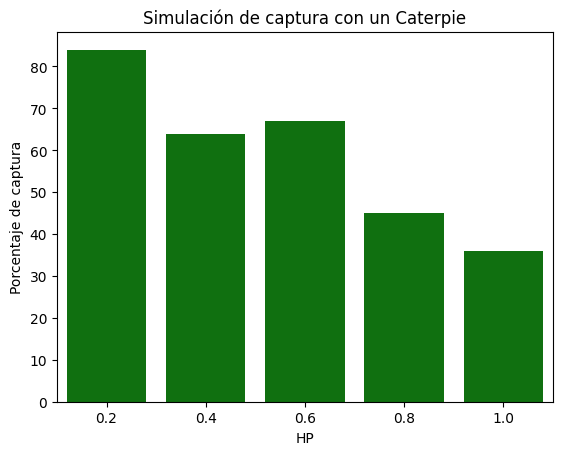

In [17]:
plot = sns.barplot(x = df.index.values.tolist(), y =df[POKEMON_NAME].values.tolist(), color = "Green")
plot.set(xlabel="HP", ylabel="Porcentaje de captura", title=f"Simulación de captura con un {POKEMON_NAME.capitalize()}")
plt.show(plot)

### 2C: Parámetros que más afectan la efectividad de captura

La pokebola usada es uno de los parámetros que más afecta la efectividad, ya que cambia mucho usar una heavyball en un Snorlax que no usarla, o usar una fastball en un Jolteon. También vimos que la ultraball aumenta el porcentaje de captura en gran medida ya que vemos hasta un x4 en las muestras obtenidas, teniendo como referencia la pokeball.
Otro parámetro es la vida actual, donde vemos un x2 (comparando desde 100% a 1% de HP) en pokemon fáciles de capturar como Caterpie, o un x10 en pokemon más difíciles como Snorlax u Onix.
Vale aclarar que en todos estos casos estamos aplicando lo que se llama en Economía el supuesto Ceteris Paribus, es decir, la suposición de que todas las demás variables que podrían afectar el resultado en cuestión, se mantienen constantes.

In [18]:
with open("ejercicio2c-config.json", "r") as file_2c:
    config_2c = json.load(file_2c)

def calculate_capture_rates(param, param_values):

    def_poke_name =  config_2c["default_pokemon_name"]
    def_hp_percentage =  config_2c["default_hp_percentage"]
    def_level =  config_2c["default_level"]
    def_status = StatusEffect[ config_2c["default_status"]]
    def_pokeball =  config_2c["default_pokeball"]

    pokemon = factory.create(def_poke_name, def_level, def_status, def_hp_percentage)
    pokeball = def_pokeball

    capture_rates = []
    for val in param_values:
        if param == 'level':
            pokemon = factory.create(def_poke_name, val, def_status, def_hp_percentage)
        elif param == 'hp_percentage':
            pokemon = factory.create(def_poke_name, def_level, def_status, val)
        elif param == 'status':
            pokemon = factory.create(def_poke_name, def_level, StatusEffect[val], def_hp_percentage)
        elif param == 'pokeball':
            pokeball = val

        success, rate = attempt_catch(pokemon, pokeball)
        capture_rates.append(rate)
    return capture_rates

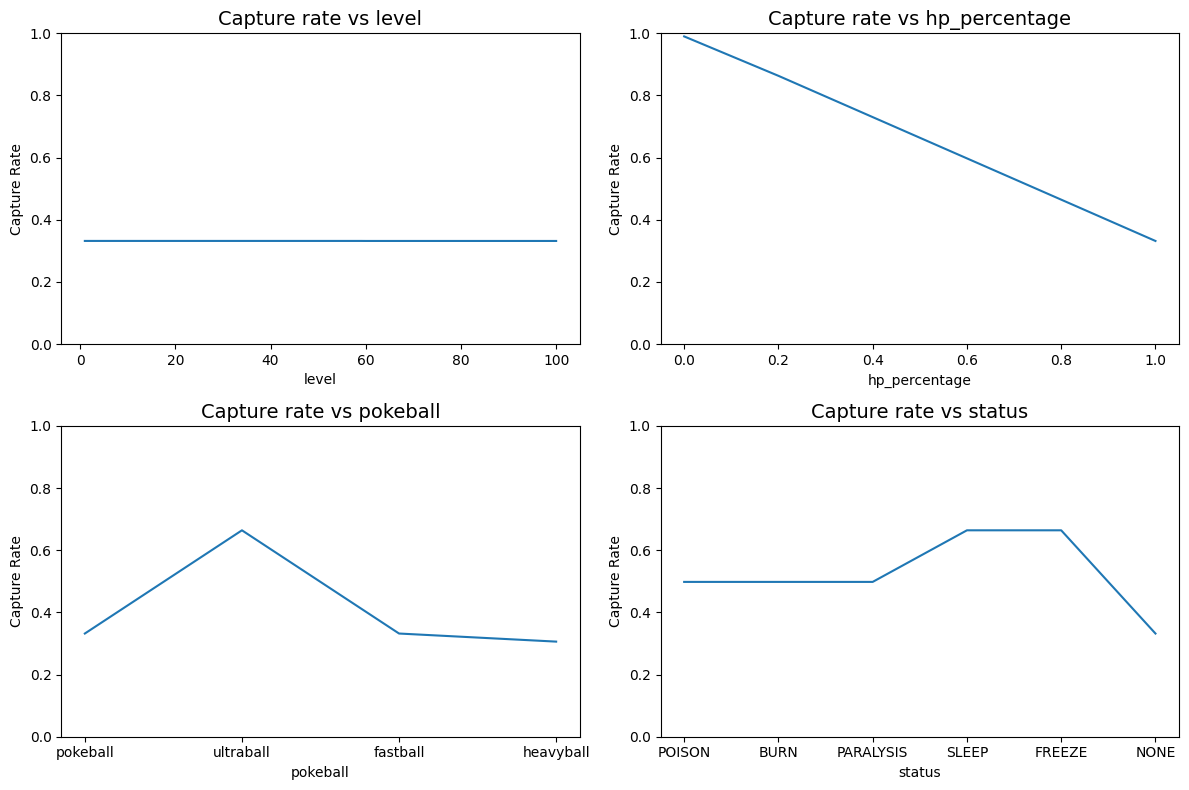

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, param in enumerate(['level', 'hp_percentage', 'pokeball', 'status']):
    capture_rates = calculate_capture_rates(param,  config_2c[param + 's']) 
    row, col = divmod(i, 2)  # Obtener la fila y la columna correspondientes a este parámetro en la matriz de subplots. Necesito axs[0,0], axs[0,1], axs[1,0], axs[1,1]
    axs[row, col].plot( config_2c[param + 's'], capture_rates)
    axs[row, col].set_xlabel(param)
    axs[row, col].set_ylabel('Capture Rate')
    axs[row, col].set_ylim([0,1])
    axs[row, col].set_title(f"Capture rate vs {param}", fontsize=14)
plt.tight_layout()
plt.show()

### 2D: Combinación de condiciones óptimas para un pokemon

Teniendo en cuenta a Onix y a Snorlax.

Vimos en el ejercicio anterior que EN PRINCIPIO el nivel no influye en lo mas minimo en la probabilidad de captura. Y decimos en principio porque teniendo en cuenta estos parámetros, un Jolteon nivel 100 es lo mismo que un nivel 1, pero en realidad el de nivel 100 tiene mas speed, por lo que sólo teniendo en cuenta eso, la fastball podría ser más eficiente en el de nivel 100.
Por esto, queda descartado para este análisis si bien el grupo entiende que capturar un Pokemon de mayor nivel, lo hace más valioso para el jugador.

In [20]:
def calculate_rate(pokemon_name, pokeball, status, level, hp_percentage):
    factory = PokemonFactory("pokemon.json")
    pokemon = factory.create(pokemon_name, level, status, hp_percentage)
    succes, rate = attempt_catch(pokemon, pokeball)
    return rate

In [21]:
with open("ejercicio2d-config.json", "r") as file_2d:
    config_2d = json.load(file_2d)

pokemon_names = [config_2d["first_pokemon"], config_2d["second_pokemon"]]
hp_percentages = config_2d["hp_percentages"]
statuses = config_2d["statuses"]
default_level = config_2d["default_level"]

rates = {}
for pokemon_name in pokemon_names:
    pokemon_rates = {}
    for hp_percentage in hp_percentages:
        for status in statuses:
            for pokeball in POKEBALLS:
                rate = calculate_rate(pokemon_name, pokeball, StatusEffect[status], default_level, hp_percentage)
                pokemon_rates[(pokeball, status, hp_percentage)] = rate
    rates[pokemon_name] = pokemon_rates

In [22]:
for pokemon_name in pokemon_names:
    max_rate = max(rates[pokemon_name].values())
    max_combination = [c for c, r in rates[pokemon_name].items() if r == max_rate][0]
    print(f"Para capturar a {pokemon_name}, la mejor combinación es: {max_combination} con probabilidad {max_rate:.2f}")

Para capturar a onix, la mejor combinación es: ('ultraball', 'SLEEP', 0.1) con probabilidad 0.66
Para capturar a snorlax, la mejor combinación es: ('heavyball', 'SLEEP', 0.1) con probabilidad 0.47


### 2E: ¿Otra combinación?

Como en el ejemplo del Jolteon, en las condiciones en las que trabajamos no es importante el nivel. En nuestro programa nivel solo mejora la salud y eso dificultaría más la batalla para bajarle la vida al pokemon a un porcentaje bajo. Pero no hay mejora de estadísticas, ni un factor que empeore el porcentaje de captura.
Tambien se podría destacar el hecho que si bien las pokeballs son un factor importante a la hora de capturar un pokemon, en el juego no siempre se tiene una cantidad razonable de ultraballs. Con esto nos referimos a que si queremos atrapar a Mewtwo nivel 100 con una pokeball nos puede resultar mucho más difícil capturarlo si no tenemos estas ultraballs.